<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2024/jax_phi4_langevin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phi-4 Theory with Langevin

In case of Gibbs-like field theory for $\varphi^4$ potential, the lattice "energy" is
$$
U(\phi) = \sum_x \left[ -2\beta \sum_{(y,x)}\phi(x)\phi(y) + (1-2\lambda)\phi(x)^2 + \lambda \phi(y)^4\right]
$$
where $x$ runs over all lattice node of a $N^d$ grid (d=2 in the use-case), $(y,x)$ means node $y$ closest to node $x$ considering on the edges a circular padding.

Notice that the $\beta$-term is the Laplacien and can be written as
$$
\sum_{(y,x)}\phi(x)\phi(y)   = \sum_{\mu=1}^d \phi(x) \phi(x+\hat{\mu})
$$
with $\hat{\mu}$ a unit-vector in the $\mu$-direction.

In fact the distrinution $Z^{-1}e^{-U(\phi)}$ is the stationnary distribution of a stochastic process. The field $\phi$ depends on the node as a matter of space disctretisation of a contnuous $x$, and of on a time $t$ discretized also in terms of a stepping evolution with intervalle $\Delta t$. The Langevin equation governes the space-time evolution of the field as
$$
\frac{\partial \phi(x,t)}{\partial t} = - \frac{\delta U(\phi)}{\delta \phi(x,t)} + \eta(x,t)
$$
with $\eta(x,t)$ is the white noise field representing the quantum
fluctuations.


The discretisation on the lattice and considering two times $t_{n+1}=t_n +\Delta t$ reads
$$
\phi(x,t_{n+1}) =  \phi(x,t_{n}) + K[\phi(x,t_{n})] \Delta t + \sqrt{\Delta t}\ \eta(x,t_n)
$$
where $ K[\phi(x,t_{n})]$ is called the drift which has the following expression
$$
K[\phi(x,t_{n})] = 2\beta \sum_{\mu=1}^d (\phi(x+\hat{\mu})+\phi(x-\hat{\mu})) + 2\phi(x)(2\lambda(1-\phi(x)^2)-1)
$$

The nb. shows how to use the Langevin equation to gather *iid* samples of fields that statistically  show that there exists a $\beta_c$ value depending on $\lambda$, where there a transition between between a phase (low beta value)  where the field fluctuate at each $x$ indépendantly, and a phase where the local field correlation (Laplacien term) starts to introduce long range correlation.


(in the code one can change the dimension $d$ but only d=2 has been tested. Now, if you have the opportunity to run on a GPU as V100 you will get better performances.)

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
from functools import partial

In [ ]:
# this is a crude test pay attetion if you run on a GPU that it pass the test
gpu = "cuda" in str(jax.devices()[0])
gpu

True

In [ ]:
def plot_3img(image1,image2, image3, title_1='',title_2='', title_3='', cmap="rainbow",
             colorbar=False, vminmax=None, figsize=(8, 4)):
    fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
    if vminmax is None:
        vmin = image1.mean() - 3*image1.std()
        vmax = image1.mean() + 3*image1.std()
    else:
        vmin,vmax=vminmax
    axs[0].imshow(image1, vmin=vmin, vmax=vmax, cmap=cmap); axs[0].set_title(title_1);
    img = axs[1].imshow(image2, vmin=vmin, vmax=vmax, cmap=cmap); axs[1].set_title(title_2);
    img = axs[2].imshow(image3, vmin=vmin, vmax=vmax, cmap=cmap); axs[2].set_title(title_3);
    axs[0].set_xticks([]); axs[1].set_xticks([]); axs[2].set_xticks([])
    axs[0].set_yticks([]); axs[1].set_yticks([]); axs[2].set_yticks([])
    if colorbar:
        fig.colorbar(img, ax=axs.ravel().tolist());

In [ ]:
def lattice_init(key,N,d):
    shape = [N for _ in range(d)]
    phi =  jnp.zeros(shape=shape)      # init with uniform field value =0
    return phi

In [ ]:
@jax.jit
def get_action(phi,uparams):
    l,k = uparams
    d=2
    action = (1 - 2 * l) * phi**2 + l * phi**4
    for mu in range(d):
        action += -2. * k * phi * jnp.roll(phi, 1, mu)
    return action.sum()


In [ ]:
@jax.jit
def get_drift(phi,uparams):
    l,k = uparams
    d=2
    drift = 2 * phi * (2 * l * (1 - phi**2) - 1)
    for mu in range(d):
        drift += 2. * k * (jnp.roll(phi, 1, mu) + jnp.roll(phi, -1, mu))

    return drift


In [ ]:
@partial(jax.jit, static_argnums=3)
def langevin(key,phi,uparams,N, dt=0.01):
    d=2
    shape = [N for _ in range(d)]
    chi = jax.random.normal(key,shape=shape)
    phi += (dt * get_drift(phi,uparams) + jnp.sqrt(dt) * chi)
    return phi


In [ ]:
def simul_scan(k, N=32, d=2, l=0.02, seed=4, n_burn=1000,n_spls=100_000,n_thinning=10,dt=0.01):
    uparams = (l,k)

    n_steps =  n_spls // n_thinning

    def body_in(i,carry):
        subkeys,phi=carry
        phi = langevin(subkeys[i],phi,uparams,N,dt)
        return subkeys,phi

    def body_out(phi,keys): # carry, x

        _,phi = jax.lax.fori_loop(0,n_thinning,body_in,(keys,phi))
        mag = jnp.mean(phi)
        mag2 = mag*mag #jnp.mean(phi2)
        #phi4 = phi2*phi2
        #mag4 = jnp.sum(phi4)
        mag4 = mag2*mag2
        return  phi,(mag,mag2,mag4)  # carry, y

    #init
    key=jax.random.PRNGKey(seed)
    key,subkey = jax.random.split(key)
    phi = lattice_init(subkey,N,d)

    #burn
    keys= jax.random.split(key,num=n_burn+1)
    key = keys[0]
    subkeys=keys[1:]
    _,phi = jax.lax.fori_loop(0,n_burn,body_in,(subkeys,phi))

    #sampling
    keys = jax.random.split(key,num=n_spls+1)
    key = keys[0]
    subkeys=keys[1:]

    subkeys=subkeys.reshape(n_steps,subkeys.shape[0]//n_steps,2)

    phi_last, mags = jax.lax.scan(body_out, phi, subkeys)

    return phi_last, mags

In [ ]:
l=0.02  # lambda
N=128    # size of the latice is N^2 (keep it <= 128)
key = jax.random.PRNGKey(4) # init random

In [ ]:
f = partial(simul_scan,N=N, d=2,l=l, seed=4, n_burn=10_000,n_spls=1_000_000,n_thinning=100,dt=0.01)

In [ ]:
betas = [0.2,0.255,0.3] # adapted for lambda = 0.02

In [ ]:
f = partial(simul_scan,N=N, d=2,l=l, seed=4, n_burn=10_000,n_spls=100,n_thinning=100,dt=0.01)
phi_last, _ = jax.jit(jax.vmap(f))(jnp.array(betas))

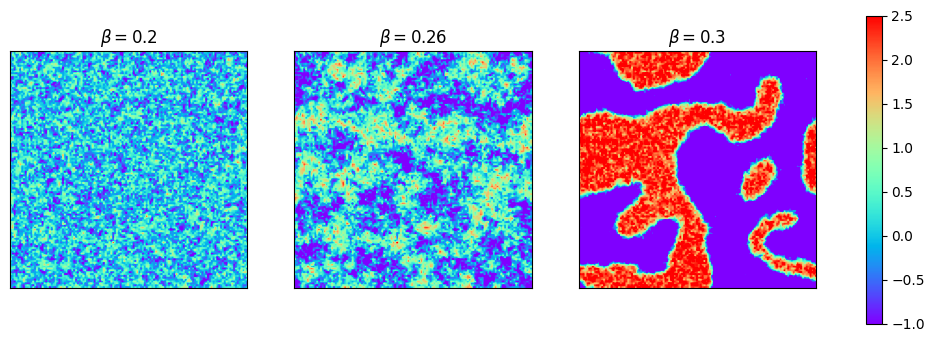

In [ ]:
plot_3img(phi_last[0],phi_last[1],phi_last[2], colorbar=True, figsize=(13, 4),
         title_1=rf"$\beta={betas[0]:.2}$",title_2=rf"$\beta={betas[1]:.2}$",title_3=rf"$\beta={betas[2]:.2}$",
          vminmax=(-1,2.5))


In [ ]:
betas = jnp.linspace(0.22,0.28,60) # adapted to l=0.02

In [ ]:
if gpu:
    # approx 1min for 10^6 samples pour N=128 with V100. On Collab T4 2min1/2
    f = partial(simul_scan,N=N, d=2,l=l, seed=10, n_burn=500_000,n_spls=1_000_000,n_thinning=10,dt=0.01)
else:
    # approx 1min for 100_000 spls N=32
    f = partial(simul_scan,N=N, d=2,l=l, seed=10, n_burn=1_000,n_spls=100_000,n_thinning=1,dt=0.01)

_, mags_info= jax.jit(jax.vmap(f))(jnp.array(betas))

In [ ]:
mags = mags_info[0]
mags2 = mags_info[1]
mags4 = mags_info[2]

In [ ]:
V = N*N # total number of nodes
n_spls_eff = mags.shape[1]  #n_spls/n_thinning

In [ ]:
mean_mags = jnp.mean(jnp.abs(mags),axis=1)
err_mags  = jnp.std(jnp.abs(mags),axis=1)

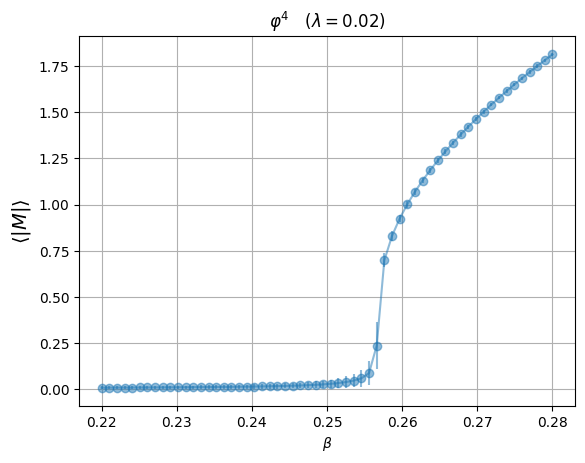

In [ ]:
errorbar(betas,mean_mags,yerr=err_mags,fmt='-o',alpha=0.5,label="simu")
grid()
xlabel(r"$\beta$")
ylabel(r"$\langle |M| \rangle$",fontsize=14)
title(rf"$\varphi^4 \quad(\lambda={l})$");

In [ ]:
mean_mags2 = jnp.mean(mags2,axis=1)
chi2 = V*(mean_mags2-(mean_mags)**2)

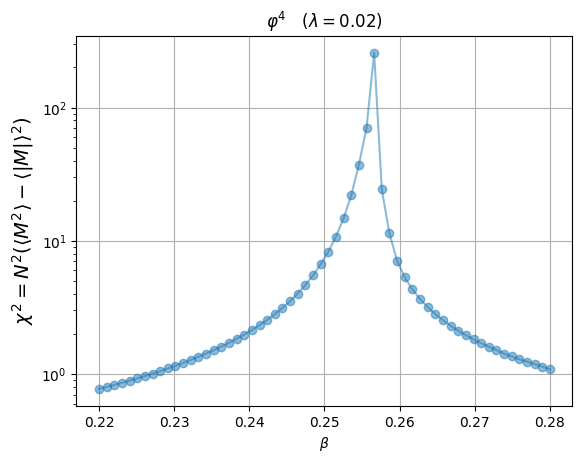

In [ ]:
errorbar(betas,chi2,yerr=0,fmt='-o',alpha=0.5,label="simu")
grid()
xlabel(r"$\beta$")
ylabel(r"$\chi^2=N^2 (\langle M^2 \rangle - \langle | M | \rangle^2)$",fontsize=14)
title(rf"$\varphi^4 \quad(\lambda={l})$");
yscale("log");

Below not good in case of low stat for beta<beta_c

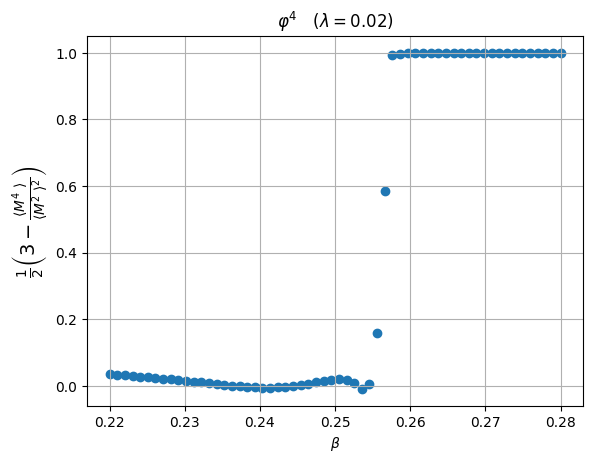

In [ ]:
if gpu:
    #errorbar(betas,UL,yerr=err_UL,fmt='-o',alpha=0.5,label="simu")
    a = np.mean(mags4,axis=1)
    b = np.mean(mags2,axis=1)
    UL = 0.5*(3-a/b**2)
    scatter(betas,0.5*(3-a/b**2))
    grid()
    xlabel(r"$\beta$")
    ylabel(r"$\frac{1}{2}\left(3-\frac{\langle M^4 \rangle}{\langle M^2 \rangle^2}\right)$",fontsize=14)
    title(rf"$\varphi^4 \quad(\lambda={l})$");